In [8]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

In [13]:
print(gp.gurobi.version())

(9, 5, 0)


In [2]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [3]:
# We append a further column to the price dataframe to define the charging hours
df_p.index = df["date"].values[:8760]
df_p.index = pd.to_datetime(df_p.index)
df_p["Hour"] = df_p.index.hour
df_p["Charging Allowed"] = df_p["Hour"].apply(lambda x: 1 if (x<9 or x>19) else 0) # defining when charging is allowed, this is later used in the optimization

# Now, we also load the 1kW nominal capacity PV generation in Hamelin
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)


In [4]:
# Here, we load dataframes with 500 EV, HH and HP profiles. The household config decides which configuration per household is selected
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [5]:
# We use this function to later easily access the outputs of the Gurobi model

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [6]:
# model settings

# Preparing an empty dataframe to store the results
df_results = pd.DataFrame()
df_results.index = df_p.index

pricing_type = "dynamic"
operation_type = "dynamic"

for idx_initial, household in household_config.iloc[:500].iterrows():
    hp_load = df_hp[household["heat_pump_profile"]]
    hh_load = df_hh[household["household_profile"]]
    ev_load = df_ev[household["household_profile"]]
    pv_size = household["pv_power"]
    bess_size = household["bess_capacity"]
    max_bess_power = household["bess_power"]

    # Initialize your environment and model
    env = gp.Env(empty=True)
    env.setParam("OutputFlag", 1)
    env.start()
    model = gp.Model("test", env=env)
    model.setParam('MIPGap', 0.001) 
    length = len(df_p)
    days = int(length/24)


    real_ev_charging = ev_load.apply(lambda x:x/1000).values
    real_ev_charging[-24:] = 0 # setting the last 24 values of ev charging = 0 to avoid model infeasibility
    max_ev_charging = max(real_ev_charging) # maximum ev charge is set at the maximum value
    allowed_charging_hours = df_p["Charging Allowed"].values

    pv_size = bess_size
    pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
    min_bess_energy = 0.05*bess_size
    feed_in_tariff = 0.001 # 0.07
    grid_charges = 0.072 # https://www.netze-bw.de/news/veroeffentlichung-vorlaeufiger-netzentgelte
    handling_fee = 0.02 # https://support.tibber.com/de/articles/4406583-wie-setzt-sich-der-monatliche-tibber-preis-zusammen

    
    # either set prices dynamically or static as average wholesale price
    if pricing_type == "dynamic":
        prices = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+grid_charges+handling_fee).values
    elif pricing_type == "constant":
        average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
        prices = np.full(length, average_price+grid_charges+handling_fee)
    else:
        raise ValueError("Pricing type not defined.")
    
    
    # transform hh and hp load to kW
    real_hh_load = hh_load.apply(lambda x:x/1000).values
    real_hp_load = hp_load.apply(lambda x:x/1000).values
    max_hp_load = real_hp_load.max()

    # Initialize variables
    #if operation_type == "dynamic":
    opt_ev_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt")
    opt_hp_load = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_hp_opt")
    opt_bess_charging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
    opt_bess_discharging = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
    opt_net_energy = model.addVars([t for t in range(length)],lb=0,vtype=GRB.CONTINUOUS,name="opt_net_energy")
    buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
    e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")


    energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "energy_costs")
    feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "feedin_profits")

    opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
    opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")


    block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name = "blocked_heatpump")


    #### ELECTRIC VEHICLE
    # Ensure that daily charging requirements are met

    if operation_type == "dynamic":
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum(opt_ev_charging[t]*allowed_charging_hours[t] for t in range(idx_start, idx_end)) == quicksum(real_ev_charging[t] for t in range(idx_start, idx_end)),"daily_charge")


        # Ensure maximum empirical EV charging is never exceeded
        model.addConstrs(opt_ev_charging[t] <= max_ev_charging for t in range(length))

        # Only charging in allowed hours
        model.addConstrs((opt_ev_charging[t] == 0 for t in range(length) if allowed_charging_hours[t] == 0), "no_charging_when_disallowed")
    elif operation_type == "constant":
        model.addConstrs(opt_ev_charging[t] == real_ev_charging[t] for t in range(length))

    #### HEAT PUMP
    # ensure maximum three blocking windows and unblocking for two hours after blocking

    if operation_type == "dynamic":

        for idx in range(days):
            idx_start = idx * 24
            idx_end = (idx + 1) * 24

            # Constraint for maximum three blocks of two hours
            two_hour_blocks = 0
            for t in range(idx_start, idx_end - 1):
                if t < idx_end - 3:
                    two_hour_blocks += model.addVar(vtype=GRB.BINARY)
                    model.addConstr(two_hour_blocks >= block_hp[t] + block_hp[t + 1] - 1)

                    # At least two hours unblock after each block
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 2]))
                    model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp[t + 3]))

            model.addConstr(two_hour_blocks <= 3, "max_three_blocks_{}".format(idx))

        # ensure that maximum empirical heat pump load is never exceeded and in non-blocking hours at least empirical load
        for t in range(length):
            model.addConstr(opt_hp_load[t]<=max_hp_load)
            model.addConstr((opt_hp_load[t]>=(1-block_hp[t])*real_hp_load[t]))

        # ensure that the daily heat demand is covered
        for idx in range(days):
            idx_start = idx*24
            idx_end = (idx+1)*24
            model.addConstr(quicksum((1-block_hp[t])*opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))


        # ensure that the sum of heat pump load every 6 hours remains in the same range
        for idx in range(days * 4):
            idx_start = idx * 6
            idx_end = (idx + 1) * 6
            if idx_end > length:
                idx_end = length  # Ensure we don't exceed the bounds
            model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) >= quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))
    
    elif operation_type == "constant":
        model.addConstrs(opt_hp_load[t] == real_hp_load[t] for t in range(length))

    #### BATTERY STORAGE
    model.addConstr(e_bess[0]==min_bess_energy)

    for t in range(length):
        model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
        model.addConstr(opt_net_energy[t] * opt_feed_out_pv[t] == 0, "mutual_exclusivity_pv_" + str(t)) # mutual exclusivity for pv feed out and net energy 
        model.addConstr(opt_bess_charging[t]<=max_bess_power)
        model.addConstr(opt_bess_discharging[t]<=max_bess_power)
        model.addConstr(opt_bess_charging[t]<=opt_internaluse_pv[t])


    for t in range(1, length):
        model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]-opt_bess_discharging[t-1])
        model.addConstr(e_bess[t]>=min_bess_energy)
        model.addConstr(e_bess[t]<=bess_size)

    ### OPTI
    # calculate net energy of household
    if operation_type == "dynamic":
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
    else:
        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+real_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))

    # energy costs
    for t in range(length):
        model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t])
        model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * prices[t] ), "calc_energy_costs_" + str(t))
        model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff, "calc_energy_profits_" + str(t))

        # final optimize

    model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE)
    model.optimize()




    vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","opt_internaluse_pv","e_bess"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
    n = length
    temp_results = get_results_in_df(model, vn, n)
    df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values




Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 143078 rows, 112785 columns and 398575 nonzeros
Model fingerprint: 0xad2c83e6
Model has 17885 quadratic constraints
Variable types: 87600 continuous, 25185 integer (25185 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 4e+01]
  QRHS range       [4e-01, 1e+02]
Presolve removed 98695 rows and 63246 columns
Presolve time: 0.41s
Presolved: 53508 rows, 58299 columns, 185552 nonzeros
Variable types: 45218 continuous, 13081 integer (13081 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log onl

KeyboardInterrupt: 

In [ ]:
if df_results.isna().any().any():
    raise ValueError("Results contain NaN values, indicating infeasibility of some models.")
else:
    df_results.to_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{str(feed_in_tariff).replace('.','')}_ne_{str(grid_charges).replace('.','')}.pkl")
    
    

In [217]:

temp_results["p_ch_real"] = real_ev_charging
temp_results["Deutschland/Luxemburg [€/kWh]"] = prices
temp_results["p_pv"] = pv_load
temp_results["p_hp_real"] = real_hp_load
temp_results["p_hh_real"] = real_hh_load
temp_results["real_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_real"] + temp_results["p_ch_real"]
temp_results["opt_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_opt"] + temp_results["p_ch_opt"]

In [218]:
# Selecting day for analysis
day = 123

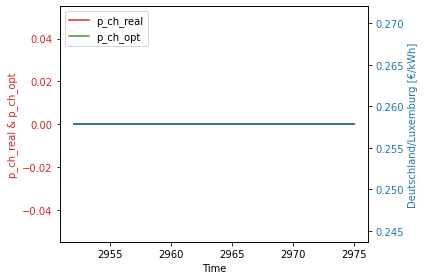

In [219]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_real'].iloc[day*24:(day+1)*24], color=color1, label='p_ch_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_ch_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



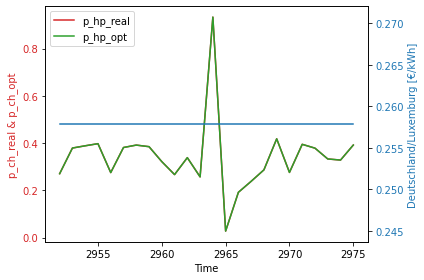

In [220]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_real'].iloc[day*24:(day+1)*24], color=color1, label='p_hp_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_hp_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



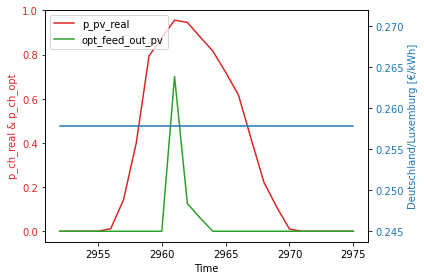

In [221]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_pv'].iloc[day*24:(day+1)*24], color=color1, label='p_pv_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()



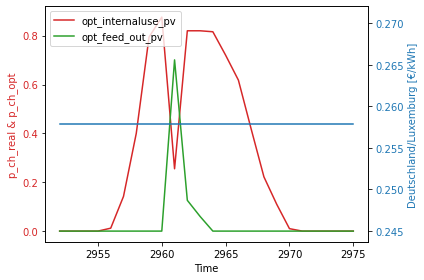

In [222]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_internaluse_pv'].iloc[day*24:(day+1)*24], color=color1, label='opt_internaluse_pv')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  #  for a neat layout
plt.show()



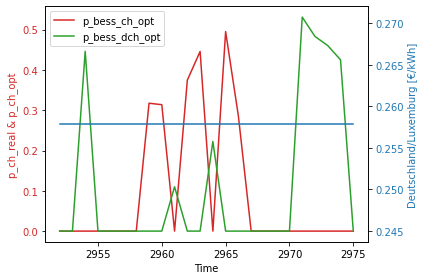

In [223]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_ch_opt'].iloc[day*24:(day+1)*24], color=color1, label='p_bess_ch_opt')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_dch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_bess_dch_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





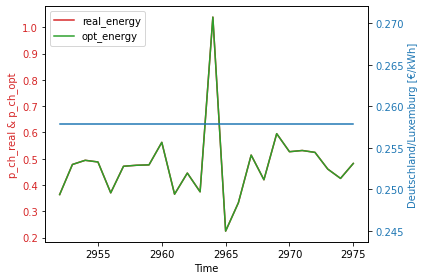

In [224]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['real_energy'].iloc[day*24:(day+1)*24], color=color1, label='real_energy')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





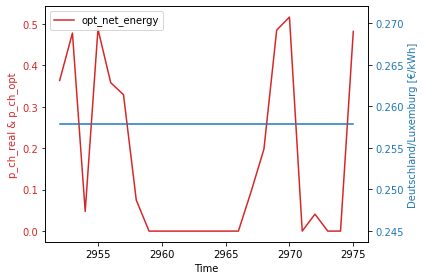

In [225]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_net_energy'].iloc[day*24:(day+1)*24], color=color1, label='opt_net_energy')
#ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
plt.show()





In [172]:
# Debugging

model.computeIIS()
model.write("model.ilp")



Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0    156948         -         0     87600         -           0s
       14        14         -         0         0         -           2s

IIS computed: 14 constraints, 0 bounds
IIS runtime: 1.82 seconds (0.33 work units)


In [161]:
household_config.iloc[:50]

,heat_pump_profile,household_profile,ev_col,ev_shift_weeks,bess_capacity,bess_power,pv_power
0,0_SFH19_P_TOT,0_SFH19_P_TOT,Bl7,48,10.0,4.100,10.0
1,1_SFH18_P_TOT,1_SFH18_P_TOT,AdO1,-24,7.5,3.075,7.5
2,2_SFH4_P_TOT,2_SFH4_P_TOT,UT2,-96,10.0,4.100,10.0
3,3_SFH30_P_TOT,3_SFH30_P_TOT,SR14,96,5.0,2.050,5.0
4,4_SFH3_P_TOT,4_SFH3_P_TOT,AdO1,-72,10.0,4.100,10.0
5,5_SFH3_P_TOT,5_SFH3_P_TOT,AsO6,-72,5.0,2.050,5.0
6,6_SFH12_P_TOT,6_SFH12_P_TOT,Bl2,48,2.5,1.025,2.5
7,7_SFH5_P_TOT,7_SFH5_P_TOT,AsO4,0,5.0,2.050,5.0
8,8_SFH18_P_TOT,8_SFH18_P_TOT,Bl2,96,7.5,3.075,7.5
9,9_SFH34_P_TOT,9_SFH34_P_TOT,NR1,72,10.0,4.100,10.0


In [ ]:
# Debugging 

if df_results.isna().any().any():
    columns_with_na = df_results.isna().any()
    columns_with_na_names = columns_with_na[columns_with_na].index.tolist()
    print(columns_with_na_names)
    
temp_ev_df = pd.DataFrame(ev_load)
temp_ev_df.index = pd.to_datetime(temp_ev_df.index)
temp_ev_df.resample("D").sum()

failed_hhs = []
transposed_config = household_config.T
for hh in columns_with_na_names:
    failed_hhs.append(transposed_config[int(hh)])
    
failed_hhs_df = pd.DataFrame(failed_hhs)


#household_config[household_config["heat_pump_profile"]=="148_SFH34_P_TOT"].index
for i in household_config.index:
    if household_config.index[i]==148:
        print(i)


failed_hhs_df